<a href="https://colab.research.google.com/github/Zexsteel900/XAI-Comparative-Analysis-of-Post-Hoc-Methods/blob/main/XAI_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install shap lime tensorflow keras matplotlib opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=47b7fef9386f991e993d5f6a41bc8fff8ee046a10cd3d69dfc2a349371cac5b2
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap

In [21]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# Convert grayscale images to RGB
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

In [22]:
# Build a simple CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), name='conv2d_1'),
    MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_1'),
    Flatten(name='flatten_1'),
    Dense(128, activation='relu', name='dense_2'),
    Dense(10, activation='softmax', name='dense_3')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_rgb, y_train, epochs=5, validation_split=0.1, verbose=2)

Epoch 1/5
1688/1688 - 8s - loss: 0.1392 - accuracy: 0.9567 - val_loss: 0.0591 - val_accuracy: 0.9835 - 8s/epoch - 5ms/step
Epoch 2/5
1688/1688 - 5s - loss: 0.0502 - accuracy: 0.9839 - val_loss: 0.0477 - val_accuracy: 0.9870 - 5s/epoch - 3ms/step
Epoch 3/5
1688/1688 - 6s - loss: 0.0311 - accuracy: 0.9900 - val_loss: 0.0541 - val_accuracy: 0.9853 - 6s/epoch - 4ms/step
Epoch 4/5
1688/1688 - 5s - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.0498 - val_accuracy: 0.9883 - 5s/epoch - 3ms/step
Epoch 5/5
1688/1688 - 6s - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.0524 - val_accuracy: 0.9880 - 6s/epoch - 4ms/step


In [23]:
# Evaluate model
loss, accuracy = model.evaluate(X_test_rgb, y_test)
print(f"Test Accuracy: {accuracy}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0447 - accuracy: 0.9858
Test Accuracy: 0.98580002784729


In [24]:
# Select a test image
test_image = X_test_rgb[0]

In [25]:
# LIME explanation
explainer_lime = lime_image.LimeImageExplainer()
explanation_lime = explainer_lime.explain_instance(
    test_image,
    model.predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)
lime_image, mask = explanation_lime.get_image_and_mask(
    explanation_lime.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


In [26]:
# SHAP explanation
explainer_shap = shap.GradientExplainer(model, X_train_rgb[:100])
shap_values = explainer_shap.shap_values(test_image[np.newaxis, ...])
shap_image = shap_values[0][0].mean(axis=-1)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [28]:
def grad_cam(input_model, image, layer_name):
    grad_model = tf.keras.models.Model(
        [input_model.inputs],
        [input_model.get_layer(layer_name).output, input_model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image]))
        loss = predictions[:, np.argmax(predictions[0])]
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    # Cast boolean tensors to float32 before multiplication
    guided_grads = tf.cast(output > 0, tf.float32) * tf.cast(grads > 0, tf.float32) * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.zeros(output.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = np.uint8(cam * 255)
    cam = np.expand_dims(cam, axis=-1)
    cam = tf.image.resize(cam, (28, 28))
    return cam.numpy()

grad_cam_image = grad_cam(model, test_image, 'conv2d_1')

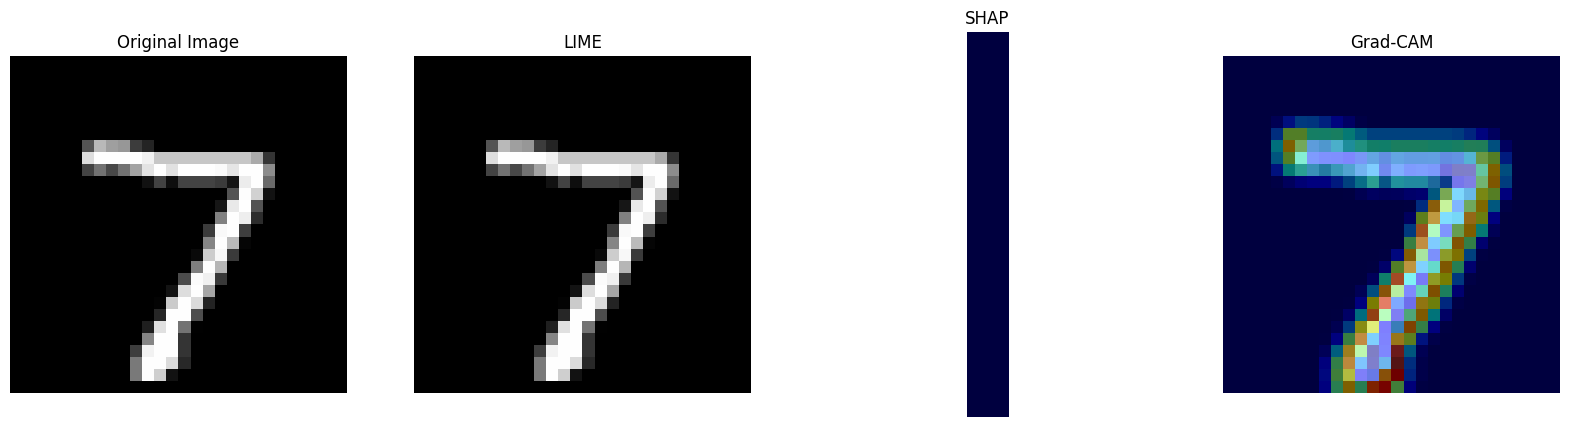

In [31]:
# Plot explanations
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(test_image.squeeze(), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# LIME
axes[1].imshow(mark_boundaries(test_image.squeeze(), mask))
axes[1].set_title("LIME")
axes[1].axis('off')

# SHAP
axes[2].imshow(test_image.squeeze(), cmap='gray')
axes[2].imshow(shap_image, cmap='jet', alpha=0.5)
axes[2].set_title("SHAP")
axes[2].axis('off')

# Grad-CAM
axes[3].imshow(test_image.squeeze(), cmap='gray')
axes[3].imshow(grad_cam_image.squeeze(), cmap='jet', alpha=0.5)
axes[3].set_title("Grad-CAM")
axes[3].axis('off')

plt.show()